## PAN–Aadhaar Linkage Risk Analysis (PALRI)

### Part 1: Structural Risk Assessment

This section estimates **state-wise PAN–Aadhaar linkage risk** by separating the problem into two clear, measurable structural components.

Rather than treating non-linkage as individual non-compliance, this analysis frames it as a **system-level delivery and access risk**.

### Key Risk Components

1. **PAN Linkage Gap**
   - Measures how many **adults with PAN are still not linked to Aadhaar**.
   - Computed relative to the **adult population**, not total population.

   **Formula**  
   `PAN Linkage Gap = 1 − (PAN Linked ÷ Adult Population)`

2. **Aadhaar Availability Risk**
   - Measures gaps in Aadhaar coverage at the population level.
   - Uses **live Aadhaar saturation** to capture availability constraints.

   **Formula**  
   `Aadhaar Availability Risk = 1 − (Live Aadhaar ÷ Total Population)`

3. **PALRI (PAN–Aadhaar Linkage Risk Index)**
   - A composite indicator capturing **structural exclusion risk**.

   **Formula**  
   `PALRI = PAN Linkage Gap + Aadhaar Availability Risk`

### Insights:
- Identifies **states where non-linkage is likely due to access or system readiness**.
- Enables **targeted administrative interventions** rather than blanket enforcement.
- Creates a defensible, transparent metric aligned with UIDAI–MeitY policy goals.

This part focuses only on **structural risk**.  
Update-related risks is analysed separately in Part 2 of the Analysis.


In [6]:

import pandas as pd

#
# LOAD DATA
# --------------------------------------------------

# PAN linked as on 2023
pan_linked = pd.read_csv("/content/PAN_linked_as_on2023.csv")

# Aadhaar saturation report 2025
aadhaar = pd.read_csv("/content/Aadhar-Saturation2025.csv")

# Population cohort estimates 2025
population = pd.read_csv("/content/population_estimation_2025.csv")

# --------------------------------------------------
# STANDARDIZE STATE NAMES
# --------------------------------------------------

pan_linked["state"] = pan_linked["Residential Address State"].str.strip()
aadhaar["state"] = aadhaar["State/Union Territory"].str.strip()
population["state"] = population["state"].str.strip()

# Keep only common states to avoid NaNs
common_states = (
    set(pan_linked["state"])
    .intersection(aadhaar["state"])
    .intersection(population["state"])
)


In [37]:
# --------------------------------------------------
# CHECK STATE MISMATCHES ACROSS DATASETS
# --------------------------------------------------

pan_states = set(pan_linked["state"])
aadhaar_states = set(aadhaar["state"])
population_states = set(population["state"])

print("States in PAN linked but NOT in Aadhaar:")
print(sorted(pan_states - aadhaar_states))

print("\nStates in PAN linked but NOT in Population:")
print(sorted(pan_states - population_states))

print("\nStates in Aadhaar but NOT in PAN linked:")
print(sorted(aadhaar_states - pan_states))

print("\nStates in Aadhaar but NOT in Population:")
print(sorted(aadhaar_states - population_states))

print("\nStates in Population but NOT in PAN linked:")
print(sorted(population_states - pan_states))

print("\nStates in Population but NOT in Aadhaar:")
print(sorted(population_states - aadhaar_states))


States in PAN linked but NOT in Aadhaar:
[]

States in PAN linked but NOT in Population:
['Telangana']

States in Aadhaar but NOT in PAN linked:
[]

States in Aadhaar but NOT in Population:
['Telangana']

States in Population but NOT in PAN linked:
[]

States in Population but NOT in Aadhaar:
[]


### Telangana cohort-wise population estimation (2025)

* Telangana is missing age-cohort population estimates in the 2025 population dataset.  
* To maintain consistency, national-average cohort shares (0–5, 5–17, 18+) are computed from all other states and applied to Telangana’s total projected population (2025).  
* This provides a neutral and defensible approximation suitable for linkage-risk analysis.


In [5]:
import pandas as pd
import numpy as np

# --------------------------------------------------
# LOAD DATA
# --------------------------------------------------

population = pd.read_csv("/content/population_estimation_2025.csv")
aadhaar = pd.read_csv("/content/Aadhar-Saturation2025.csv")

population["state"] = population["state"].str.strip()
aadhaar["state"] = aadhaar["State/Union Territory"].str.strip()

# --------------------------------------------------
# ENSURE NUMERIC
# --------------------------------------------------

population_cols = [
    "age_0_5_2025",
    "age_5_17_2025",
    "adult_18_plus_2025",
    "total_pop_2025"
]

for col in population_cols:
    population[col] = pd.to_numeric(population[col], errors="coerce")

aadhaar["Total population (Projected for 2025)"] = pd.to_numeric(
    aadhaar["Total population (Projected for 2025)"],
    errors="coerce"
)

# --------------------------------------------------
# GET TELANGANA TOTAL POPULATION
# --------------------------------------------------

telangana_total = aadhaar.loc[
    aadhaar["state"] == "Telangana",
    "Total population (Projected for 2025)"
].iloc[0]

# Check if telangana_total is NaN, which indicates missing or non-numeric data
if pd.isna(telangana_total):
    raise ValueError(
        "Telangana's total population is missing or non-numeric in the 'Aadhar-Saturation2025.csv' dataset. "
        "Please check the data quality for 'Total population (Projected for 2025)' for Telangana."
    )
else:
    telangana_total = float(telangana_total)

# --------------------------------------------------
# CLEAN DATA BEFORE COMPUTING SHARES
# --------------------------------------------------

pop_valid = population[
    (population["state"] != "Telangana") &
    (population["total_pop_2025"].notna()) &
    (population["total_pop_2025"] > 0)
].copy()

# --------------------------------------------------
# COMPUTE NATIONAL COHORT SHARES
# --------------------------------------------------

# Check if pop_valid is empty to avoid division by zero or NaN results for national_shares
if pop_valid.empty:
    raise ValueError("No valid states found to compute national cohort shares. Ensure population data is present and correctly formatted for states other than Telangana.")

pop_valid["share_0_5"] = pop_valid["age_0_5_2025"] / pop_valid["total_pop_2025"]
pop_valid["share_5_17"] = pop_valid["age_5_17_2025"] / pop_valid["total_pop_2025"]
pop_valid["share_18_plus"] = pop_valid["adult_18_plus_2025"] / pop_valid["total_pop_2025"]

national_shares = pop_valid[
    ["share_0_5", "share_5_17", "share_18_plus"]
].mean()

# Check if national_shares are NaN, which can happen if pop_valid was all zeros or had NaNs
if national_shares.isna().any():
    raise ValueError("National cohort shares could not be computed due to issues in population data. Please check 'pop_valid' dataframe.")


# --------------------------------------------------
# ESTIMATE TELANGANA COHORTS
# --------------------------------------------------

telangana_estimated = {
    "state": "Telangana",
    "age_0_5_2025": int(round(telangana_total * national_shares["share_0_5"])),
    "age_5_17_2025": int(round(telangana_total * national_shares["share_5_17"])),
    "adult_18_plus_2025": int(round(telangana_total * national_shares["share_18_plus"])),
    "total_pop_2025": int(round(telangana_total))
}

telangana_estimated

{'state': 'Telangana',
 'age_0_5_2025': 1398714,
 'age_5_17_2025': 3046195,
 'adult_18_plus_2025': 34009077,
 'total_pop_2025': 38454000}

The computed cohortwise shares are used in the dataset for Telangana alone.
{'state': 'Telangana',
 'age_0_5_2025': 1398714,
 'age_5_17_2025': 3046195,
 'adult_18_plus_2025': 34009077,
 'total_pop_2025': 38454000}

In [7]:

# PREPARE REQUIRED COLUMNS
# --------------------------------------------------

pan_linked = pan_linked.rename(columns={
    "Pan Count": "pan_linked_2023"
})

aadhaar = aadhaar.rename(columns={
    "Total population (Projected for 2025)": "total_population_2025",
    "Estimated numbers of Aadhaar assigned (Live)": "live_aadhaar_2025"
})

# Convert to numeric
pan_linked["pan_linked_2023"] = pd.to_numeric(
    pan_linked["pan_linked_2023"], errors="coerce"
)

aadhaar["total_population_2025"] = pd.to_numeric(
    aadhaar["total_population_2025"], errors="coerce"
)

aadhaar["live_aadhaar_2025"] = pd.to_numeric(
    aadhaar["live_aadhaar_2025"], errors="coerce"
)

population["adult_18_plus_2025"] = pd.to_numeric(
    population["adult_18_plus_2025"], errors="coerce"
)

# --------------------------------------------------
# MERGE DATASETS
# --------------------------------------------------

df = (
    pan_linked
    .merge(
        population[["state", "adult_18_plus_2025"]],
        on="state",
        how="inner"
    )
    .merge(
        aadhaar[["state", "total_population_2025", "live_aadhaar_2025"]],
        on="state",
        how="inner"
    )
)


### **Computing PAN LInkage Gap and Aadhaar Availability Risk**

In [9]:
#1: PAN LINKAGE GAP
# --------------------------------------------------

df["pan_linkage_gap"] = 1 - (
    df["pan_linked_2023"] / df["adult_18_plus_2025"]
)


df["pan_linkage_gap"] = df["pan_linkage_gap"].round(4)

# --------------------------------------------------
# 2: AADHAAR AVAILABILITY RISK
# --------------------------------------------------

df["aadhaar_availability_risk"] = 1 - (
    df["live_aadhaar_2025"] / df["total_population_2025"]
)

df["aadhaar_availability_risk"] = df["aadhaar_availability_risk"].round(4)


In [12]:
df.head(10)

Sl. No.             Residential Address State  pan_linked_2023  \
0        1           Andaman and Nicobar Islands           235107   
1        2                        Andhra Pradesh         24726158   
2        3                     Arunachal Pradesh           715204   
3        4                                 Assam         12813323   
4        5                                 Bihar         42323312   
5        6                            Chandigarh           745605   
6        7  Dadra & Nagar Haveli and Daman & Diu           373330   
7        9                                 Delhi         13837680   
8       10                                   Goa          1003876   
9       11                               Gujarat         27452095   

                                  state  adult_18_plus_2025  \
0           Andaman and Nicobar Islands              361552   
1                        Andhra Pradesh            80351738   
2                     Arunachal Pradesh             1314541   
3                                 Assam            29645297   
4                                 Bihar            98894479   
5                            Chandigarh             1002678   
6  Dadra & Nagar Haveli and Daman & Diu              557609   
7                                 Delhi            15948544   
8                                   Goa             1385618   
9                               Gujarat            57417707   

   total_population_2025  live_aadhaar_2025  pan_linkage_gap  \
0                 405000             384689           0.3497   
1               53524000           53156855           0.6923   
2                1590000            1246781           0.4559   
3               36382000           33534420           0.5678   
4              130429000          115572553           0.5720   
5                1255000            1129526           0.2564   
6                 662703             692657           0.3305   
7               22146000           23017965           0.1324   
8                1591000            1639302           0.2755   
9               73227000           66346971           0.5219   

   aadhaar_availability_risk  
0                     0.0502  
1                     0.0069  
2                     0.2159  
3                     0.0783  
4                     0.1139  
5                     0.1000  
6                    -0.0452  
7                    -0.0394  
8                    -0.0304  
9                     0.0940

### Negative Aadhaar availability values indicate saturation exceeding population projections and are interpreted as zero availability risk.
### Accordingly,
### **Aadhaar Availability Risk is floored at zero to ensure PALRI captures only meaningful access constraints.**

In [13]:
df["aadhaar_availability_risk"] = df["aadhaar_availability_risk"].clip(lower=0)


### Computing **PALRI (PAN–Aadhaar Linkage Risk Index)**
   - A composite indicator capturing **structural exclusion risk**.

   **Formula**  
   `PALRI = PAN Linkage Gap + Aadhaar Availability Risk`

In [15]:
# 3: PALRI COMPUTATION
# --------------------------------------------------

df["PALRI"] = (
    df["pan_linkage_gap"] +
    df["aadhaar_availability_risk"]
).round(4)


# FINAL OUTPUT
# --------------------------------------------------

palri_df = df[[
    "state",
    "pan_linked_2023",
    "adult_18_plus_2025",
    "pan_linkage_gap",
    "aadhaar_availability_risk",
    "PALRI"
]].sort_values("PALRI", ascending=False)



In [18]:
palri_df.head()

state  pan_linked_2023  adult_18_plus_2025  pan_linkage_gap  \
21         Nagaland           605556             1879577           0.6778   
19        Meghalaya           463788             2818545           0.8355   
12  Jammu & Kashmir          4669709            11914237           0.6081   
18          Manipur          1209847             2713004           0.5541   
20          Mizoram           305405             1042346           0.7070   

    aadhaar_availability_risk   PALRI  
21                     0.3723  1.0501  
19                     0.1689  1.0044  
12                     0.1253  0.7334  
18                     0.1762  0.7303  
20                     0.0188  0.7258

## PAN–Aadhaar Linkage Risk (PALRI) Classification

To make the PAN–Aadhaar Linkage Risk Index (PALRI) easier to interpret and act upon, states are grouped into **High**, **Medium**, and **Low** risk categories.



In [19]:
import pandas as pd

# Copy to avoid overwriting
palri_classified = palri_df.copy()

# Quantile-based risk classification
q_low = palri_classified["PALRI"].quantile(0.33)
q_high = palri_classified["PALRI"].quantile(0.66)

def classify_risk(val):
    if val >= q_high:
        return "High Risk"
    elif val >= q_low:
        return "Medium Risk"
    else:
        return "Low Risk"

palri_classified["PALRI_Risk_Category"] = palri_classified["PALRI"].apply(classify_risk)

palri_classified.head()


state  pan_linked_2023  adult_18_plus_2025  pan_linkage_gap  \
21         Nagaland           605556             1879577           0.6778   
19        Meghalaya           463788             2818545           0.8355   
12  Jammu & Kashmir          4669709            11914237           0.6081   
18          Manipur          1209847             2713004           0.5541   
20          Mizoram           305405             1042346           0.7070   

    aadhaar_availability_risk   PALRI PALRI_Risk_Category  
21                     0.3723  1.0501           High Risk  
19                     0.1689  1.0044           High Risk  
12                     0.1253  0.7334           High Risk  
18                     0.1762  0.7303           High Risk  
20                     0.0188  0.7258           High Risk

### **High Risk states**

In [20]:
high_risk_states = (
    palri_classified
    [palri_classified["PALRI_Risk_Category"] == "High Risk"]
    [["state", "PALRI"]]
    .sort_values("PALRI", ascending=False)
)

high_risk_states


state   PALRI
21           Nagaland  1.0501
19          Meghalaya  1.0044
12    Jammu & Kashmir  0.7334
18            Manipur  0.7303
20            Mizoram  0.7258
1      Andhra Pradesh  0.6992
33          Jharkhand  0.6876
4               Bihar  0.6859
22             Odisha  0.6823
2   Arunachal Pradesh  0.6718
16     Madhya Pradesh  0.6706
3               Assam  0.6461

In [21]:
def palri_color(val):
    if val == "High Risk":
        return "background-color: #f8d7da"   # light red
    elif val == "Medium Risk":
        return "background-color: #fff3cd"   # light yellow
    else:
        return "background-color: #d4edda"   # light green

styled_palri_table = (
    palri_classified[["state", "PALRI", "PALRI_Risk_Category"]]
    .sort_values("PALRI", ascending=False)
    .style
    .applymap(palri_color, subset=["PALRI_Risk_Category"])
    .format({"PALRI": "{:.3f}"})
)

styled_palri_table


/tmp/ipython-input-925070521.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(palri_color, subset=["PALRI_Risk_Category"])


## Geographic Mapping of PAN–Aadhaar Linkage Risk

A state-wise risk map is created to visually represent the **spatial distribution of PAN–Aadhaar linkage risk across India**.

- States are color-coded into **High (Red)**, **Medium (Yellow)**, and **Low (Green)** risk zones based on PALRI.
- This visualization makes regional patterns and clusters immediately visible.
- The map supports **policy prioritization, regional monitoring, and last-mile intervention planning**.

Requirement:
geopandas , an India states shapefile
(Here: States_Mapping_Shapefiles- Folder downloaded from free open source- DataMeet India Maps)

Map saved to: /content/PALRI_India_Risk_Map.png


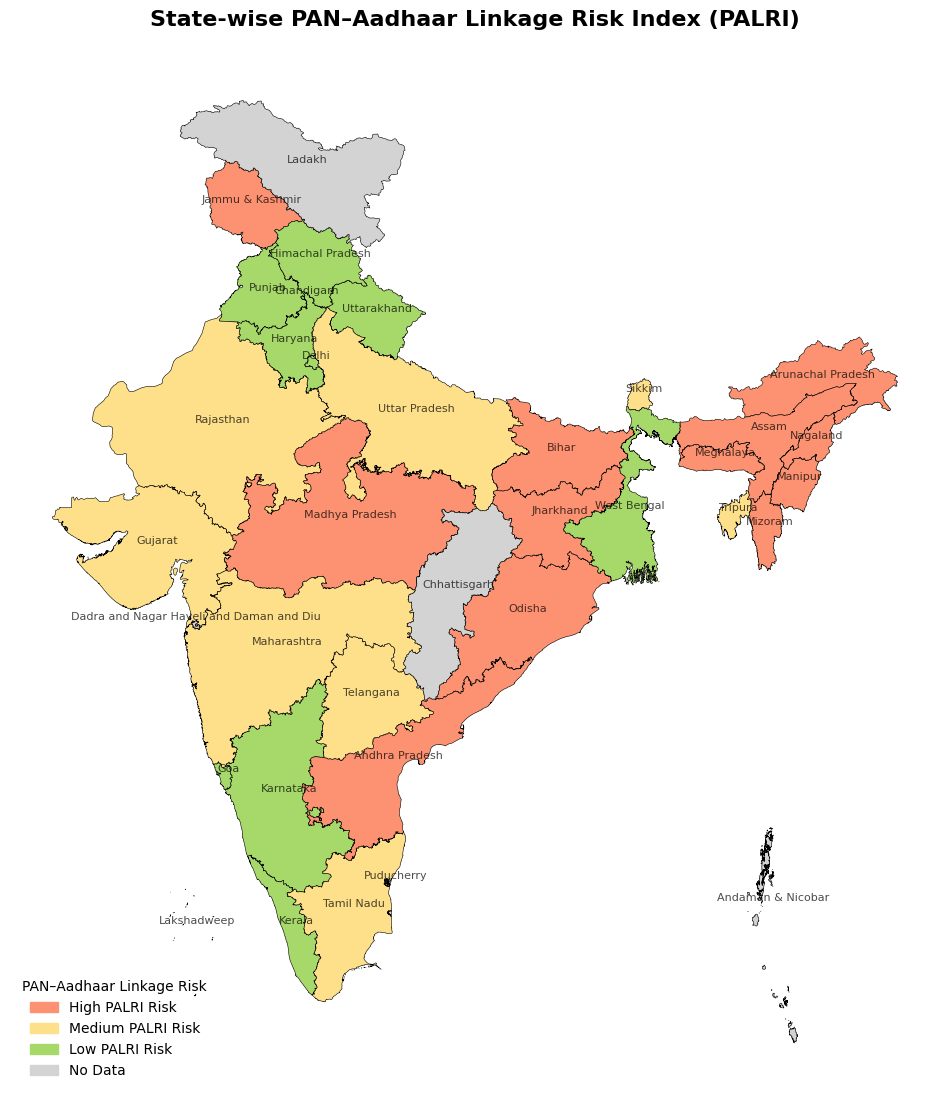

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load India states shapefile
india_map = gpd.read_file("/content/Admin2.shp")

# Standardize state names, using 'ST_NM' as identified
india_map["state"] = india_map["ST_NM"].str.strip()

# Merge with PALRI data
map_df = india_map.merge(
    palri_classified,
    on="state",
    how="left"
)

# Fill NaN values in 'PALRI_Risk_Category' with 'No Data' to ensure all states have a category
map_df["PALRI_Risk_Category"] = map_df["PALRI_Risk_Category"].fillna("No Data")

# Risk color mapping with lighter, professional shades for High/Low risk
risk_colors = {
    "High Risk": "#fc9272",     # Lighter, slightly desaturated red-orange
    "Medium Risk": "#fee08b",   # Yellow (retained)
    "Low Risk": "#a6d96a",       # Lighter, muted green
    "No Data": "#d3d3d3"        # Light grey for no data
}

map_df["color"] = map_df["PALRI_Risk_Category"].map(risk_colors)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 14))
map_df.plot(
    ax=ax,
    color=map_df["color"],
    edgecolor="black",
    linewidth=0.4
)

# Add state names subtly
for idx, row in map_df.iterrows():
    # Label all states, regardless of data availability
    centroid = row.geometry.centroid
    ax.annotate(
        text=row["state"],
        xy=(centroid.x, centroid.y),
        xytext=(3, 3), # Offset text slightly
        textcoords="offset points",
        ha='center',
        fontsize=8,    # Smaller font size
        color='black', # Black text for contrast
        alpha=0.7      # Slightly transparent
    )

# Legend
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color=risk_colors["High Risk"], label="High PALRI Risk"),
    mpatches.Patch(color=risk_colors["Medium Risk"], label="Medium PALRI Risk"),
    mpatches.Patch(color=risk_colors["Low Risk"], label="Low PALRI Risk"),
    mpatches.Patch(color=risk_colors["No Data"], label="No Data"),
]

ax.legend(
    handles=legend_handles,
    title="PAN–Aadhaar Linkage Risk",
    loc="lower left",
    frameon=False # Remove legend frame for cleaner look
)

ax.set_title(
    "State-wise PAN–Aadhaar Linkage Risk Index (PALRI)",
    fontsize=16,
    fontweight="bold",
    pad=20 # Add some padding to the title
)

ax.axis("off")

# Save the map as an image BEFORE plt.show()
map_image_path = '/content/PALRI_India_Risk_Map.png'
plt.savefig(map_image_path, dpi=300, bbox_inches='tight')
print(f"Map saved to: {map_image_path}")

plt.show()

### Part 2: Diagnostic Analysis of High PALRI States



* In **Part 1**, we identified states with high PAN–Aadhaar Linkage Risk (PALRI).

* In **Part 2**, we now diagnose the reasons behind this risk

This is done using Bivariate analysis:

* **PALRI × Inclusion Risk** → to see whether linkage gaps are driven by population inclusion challenges

* **PALRI × Update Volatility** → to check whether frequent demographic or biometric updates are related to the risk

In [ ]:
# PALRI × Inclusion Risk (Bivariate Analysis)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt


# LOAD DATA
# -------------------------------

# High PALRI states (from Part 1)
palri_high = pd.DataFrame({
    "state": [
        "Nagaland", "Meghalaya", "Jammu & Kashmir", "Manipur", "Mizoram",
        "Andhra Pradesh", "Jharkhand", "Bihar", "Odisha",
        "Arunachal Pradesh", "Madhya Pradesh", "Assam"
    ],
    "PALRI": [
        1.0501, 1.0044, 0.7334, 0.7303, 0.7258,
        0.6992, 0.6876, 0.6859, 0.6823,
        0.6718, 0.6706, 0.6461
    ]
})

# Inclusion Risk data
inclusion = pd.read_csv("/content/inclusion_risk_ranking.csv")

# Standardize state names
palri_high["state"] = palri_high["state"].str.strip()
inclusion["state"] = inclusion["state"].str.strip()

# -------------------------------
# MERGE
# -------------------------------

df_inc = palri_high.merge(
    inclusion,
    on="state",
    how="left"
)


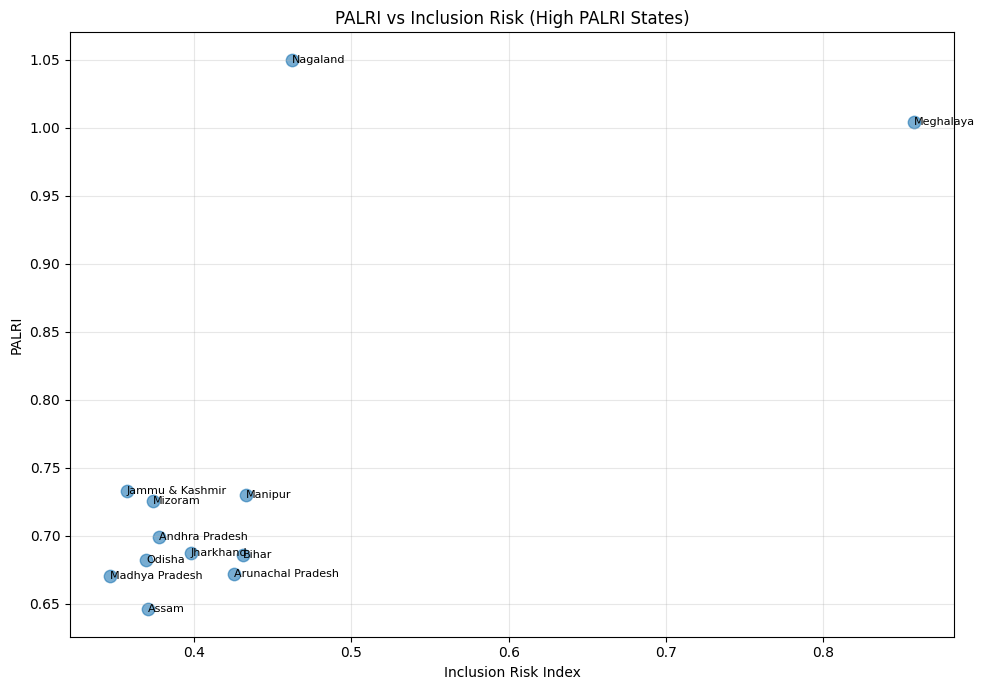

In [60]:
# VISUAL 1: Scatter – PALRI vs Inclusion Risk Index
# -------------------------------

plt.figure(figsize=(10, 7)) # Increased figure size for better spacing
plt.scatter(
    df_inc["inclusion_risk_index"],
    df_inc["PALRI"],
    s=80,
    alpha=0.6 # Make the dots lighter for better text visibility
)

for _, row in df_inc.iterrows():
    plt.text(
        row["inclusion_risk_index"], # x-coordinate for text
        row["PALRI"],                 # y-coordinate for text
        row["state"],
        fontsize=8,
        ha="left",                    # Horizontal alignment: left, so text extends to the right
        va="center",                  # Vertical alignment: center, to align text with the point
        rotation_mode='anchor'        # Rotate around the text anchor point
    )

plt.xlabel("Inclusion Risk Index")
plt.ylabel("PALRI")
plt.title("PALRI vs Inclusion Risk (High PALRI States)")
plt.grid(alpha=0.3)
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

### Key Observations from the Scatter Plot

Clear **positive** association between PALRI and Inclusion Risk:

* States with very high PALRI (e.g., Nagaland, Meghalaya, Manipur, Mizoram) also show High Inclusion Risk

* This indicates that linkage challenges are associated with structural access and participation gaps

**Meghalaya and Nagaland**  stand out:

They combine:

* **Very high PALRI**

* **Very high Inclusion Risk**

These states represent systemic vulnerability zones, not short-term compliance gaps

Large states like **Andhra Pradesh and Madhya Pradesh**:

* Despite high PALRI, they show
**Low to Stable Inclusion Risk**.
Suggests that their linkage gap is scale-driven, not access-driven

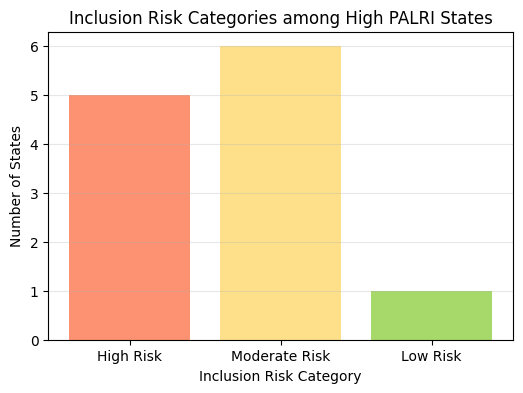

In [54]:
# VISUAL 2: Count of Inclusion Risk Categories
# -------------------------------

# Define colors for risk categories
risk_category_colors = {
    "High Risk": "#fc9272",    # Lighter red-orange
    "Moderate Risk": "#fee08b", # Yellow
    "Low Risk": "#a6d96a"     # Lighter green
}

# Define the desired order for risk categories
category_order = ["High Risk", "Moderate Risk", "Low Risk"]

# Get value counts and convert 'Risk Category' to a categorical type with the desired order
category_counts = df_inc["risk_category"].value_counts().reindex(category_order).fillna(0)

plt.figure(figsize=(6, 4))
plt.bar(
    category_counts.index, # Categories on x-axis
    category_counts.values, # Counts on y-axis
    color=[risk_category_colors.get(cat, '#cccccc') for cat in category_counts.index] # Apply colors, default to grey if category not found
)

plt.title("Inclusion Risk Categories among High PALRI States")
plt.xlabel("Inclusion Risk Category")
plt.ylabel("Number of States")
plt.grid(axis="y", alpha=0.3)
plt.show()

Among High PALRI states:

* Majority fall under Moderate to High Inclusion Risk

* Only one state appears in Low Inclusion Risk

This confirms that PALRI is aligned with inclusion stress, validating the index design

In [ ]:
# Overlay: Update Volatility (Demographic + Biometric)

In [48]:
# LOAD VOLATILITY DATA
# -------------------------------

demo_vol = pd.read_csv("/content/demographic_volatility_risk.csv")
bio_vol = pd.read_csv("/content/biometric_volatility_risk.csv")

# Standardize state names
demo_vol["state"] = demo_vol["state"].str.strip()
bio_vol["state"] = bio_vol["state"].str.strip()

# -------------------------------
# MERGE WITH HIGH PALRI STATES
# -------------------------------

df_vol = palri_high.merge(
    demo_vol[["state", "risk_category"]],
    on="state",
    how="left"
).rename(columns={"risk_category": "demographic_volatility_risk"})

df_vol = df_vol.merge(
    bio_vol[["state", "risk_category"]],
    on="state",
    how="left"
).rename(columns={"risk_category": "biometric_volatility_risk"})



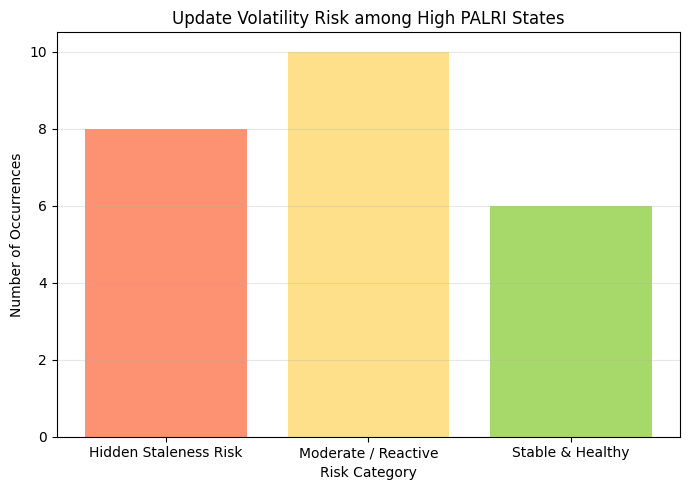

In [56]:
# VISUAL 1: Volatility Risk Distribution
# -------------------------------

# Define colors for risk categories
volatility_risk_colors = {
    "Hidden Staleness Risk": "#fc9272",  # Lighter red-orange for higher risk
    "Moderate / Reactive": "#fee08b",   # Yellow for moderate risk
    "Stable & Healthy": "#a6d96a"      # Lighter green for lower risk
}

# Define the desired order for risk categories (from higher to lower risk)
volatility_category_order = [
    "Hidden Staleness Risk",
    "Moderate / Reactive",
    "Stable & Healthy"
]

vol_counts = (
    df_vol[["demographic_volatility_risk", "biometric_volatility_risk"]]
    .melt(var_name="Volatility Type", value_name="Risk Category")
)

# Reindex to ensure desired order and fill any missing counts with 0
final_vol_counts = vol_counts["Risk Category"].value_counts().reindex(volatility_category_order).fillna(0)

plt.figure(figsize=(7, 5))
plt.bar(
    final_vol_counts.index,
    final_vol_counts.values,
    color=[volatility_risk_colors.get(cat, '#cccccc') for cat in final_vol_counts.index] # Apply colors, default to grey if category not found
)

plt.title("Update Volatility Risk among High PALRI States")
plt.xlabel("Risk Category")
plt.ylabel("Number of Occurrences")
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=0) # Remove rotation for straight labels
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

In [50]:
# VISUAL 2: State-wise Volatility Profile
# -------------------------------

df_vol.set_index("state")[[
    "demographic_volatility_risk",
    "biometric_volatility_risk"
]]

demographic_volatility_risk biometric_volatility_risk
state                                                                  
Nagaland                Hidden Staleness Risk       Moderate / Reactive
Meghalaya               Hidden Staleness Risk     Hidden Staleness Risk
Jammu & Kashmir           Moderate / Reactive       Moderate / Reactive
Manipur                 Hidden Staleness Risk     Hidden Staleness Risk
Mizoram                 Hidden Staleness Risk     Hidden Staleness Risk
Andhra Pradesh               Stable & Healthy          Stable & Healthy
Jharkhand                 Moderate / Reactive       Moderate / Reactive
Bihar                     Moderate / Reactive       Moderate / Reactive
Odisha                    Moderate / Reactive          Stable & Healthy
Arunachal Pradesh       Hidden Staleness Risk       Moderate / Reactive
Madhya Pradesh               Stable & Healthy       Moderate / Reactive
Assam                        Stable & Healthy          Stable & Healthy

### Key Observations from the Volatility Table & Bar Chart

### 🔴 **Hidden Staleness Risk dominates High PALRI states**
States such as:
- **Nagaland**
- **Meghalaya**
- **Manipur**
- **Mizoram**
- **Arunachal Pradesh**

**Observed pattern:**
- Classified under **Hidden Staleness Risk** for:
  - *Demographic updates*
  - *Often biometric updates as well*

**Interpretation:**
- Updates are **low in overall volume** and **highly irregular**
- Indicates **latent data ageing**, where records remain outdated for long periods




### 🟡 **Moderate / Reactive states**
States including:
- **Bihar**
- **Jharkhand**
- **Jammu & Kashmir**

**Observed pattern:**
- Updates occur **only in response to specific events**
- Lack of steady, preventive update behaviour

**Interpretation:**
- Reflects **event-driven correction**



### 🟢 **Stable & Healthy Updates**
States such as:
- **Andhra Pradesh**
- **Assam**

**Observed pattern:**
- Classified as **Stable & Healthy** for update behaviour
- Regular and consistent update volumes

**Interpretation:**
- Despite relatively high PALRI, Aadhaar systems are **operationally robust**
- Linkage gaps here are more likely driven by **scale, timing, or process load**
- Not by Aadhaar availability or update readiness
